In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from IPython.display import display
from scipy.optimize import fsolve

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Read trades from CSV
trades_df = pd.read_csv('trades.csv')
trades_df['Date'] = pd.to_datetime(trades_df['Date'])

# Read cashflows (deposits and withdrawals) from CSV
try:
    cashflows_df = pd.read_csv('cashflows.csv')
    cashflows_df['Date'] = pd.to_datetime(cashflows_df['Date'])
    # Store original amount for IRR calculation
    cashflows_df['Original_Amount'] = cashflows_df['Amount']
    # Convert Amount: positive for deposits, negative for withdrawals (for portfolio calculation)
    cashflows_df['Amount'] = cashflows_df.apply(
        lambda row: row['Original_Amount'] if row['Type'] == 'Deposit' else -row['Original_Amount'],
        axis=1
    )
    print("Cashflows loaded:")
    display(cashflows_df[['Date', 'Type', 'Original_Amount', 'Description']])
except FileNotFoundError:
    cashflows_df = pd.DataFrame(columns=['Date', 'Type', 'Amount', 'Original_Amount', 'Description'])
    print("No cashflows.csv file found. Using only trades.")

# Sort by date
trades_df = trades_df.sort_values('Date').reset_index(drop=True)
if len(cashflows_df) > 0:
    cashflows_df = cashflows_df.sort_values('Date').reset_index(drop=True)

# Calculate transaction fees
# Fee = |Total_Value| - (|Quantity| * Price)
# For buys: Total_Value is negative, so |Total_Value| > (Quantity * Price) → fee is positive
# For sells: Total_Value is positive, so (Quantity * Price) > |Total_Value| → fee is positive
# Use absolute value to ensure fee is always positive (it's a cost)
expected_value = trades_df['Quantity'].abs() * trades_df['Price']
trades_df['Fee_SEK'] = (trades_df['Total_Value'].abs() - expected_value).abs()

# Calculate fee as percentage of the transaction value
# Fee percentage = (Fee / (|Quantity| * Price)) * 100
trades_df['Fee_Percentage'] = (trades_df['Fee_SEK'] / expected_value) * 100

# Round for display
trades_df['Fee_SEK'] = trades_df['Fee_SEK'].round(2)
trades_df['Fee_Percentage'] = trades_df['Fee_Percentage'].round(2)

print("Trades loaded:")
display(trades_df)
print(f"\nTotal trades: {len(trades_df)}")



Cashflows loaded:


,Date,Type,Original_Amount,Description
0,2025-11-21,Deposit,119.05,NaN
1,2025-11-24,Deposit,932.40,NaN
2,2025-11-25,Deposit,901.35,NaN
3,2025-11-25,Deposit,992.59,NaN


Trades loaded:


,Date,Account,Action,Stock,Quantity,Price,Total_Value,Fee_SEK,Fee_Percentage
0,2025-11-21,6530734,Köp,SCA B,1,118.05,-119.05,1.00,0.85
1,2025-11-24,6530734,Köp,SAAB B,2,465.50,-932.40,1.40,0.15
2,2025-11-25,6530734,Köp,Ericsson B,11,90.10,-992.59,1.49,0.15
3,2025-11-25,6530734,Köp,SAAB B,2,450.00,-901.35,1.35,0.15
4,2025-11-26,6530734,Sälj,SCA B,-1,122.60,121.60,1.00,0.82
5,2025-11-27,6530734,Sälj,SAAB B,-4,475.00,1897.15,2.85,0.15
6,2025-11-27,6530734,Sälj,Ericsson B,-11,91.02,999.72,1.50,0.15



Total trades: 7


In [62]:
# Calculate current positions (holdings)
positions = {}

for _, trade in trades_df.iterrows():
    stock = trade['Stock']
    quantity = trade['Quantity']
    
    if stock not in positions:
        positions[stock] = 0
    
    positions[stock] += quantity

# Filter out positions with zero quantity
current_positions = {stock: qty for stock, qty in positions.items() if qty != 0}

print("Current Portfolio Positions:")
if current_positions:
    positions_df = pd.DataFrame([
        {'Stock': stock, 'Quantity': qty} 
        for stock, qty in current_positions.items()
    ])
    display(positions_df)
else:
    print("No open positions - all positions have been closed")



Current Portfolio Positions:
No open positions - all positions have been closed


In [ ]:
# Calculate portfolio value over time
# Track cash, positions, and NAV (Net Asset Value) using latest purchase prices
# Portfolio value = Cash + NAV (always)

# Combine trades and cashflows into a single timeline
all_events = []

# Add trades
for _, trade in trades_df.iterrows():
    all_events.append({
        'Date': trade['Date'],
        'Type': 'Trade',
        'Action': trade['Action'],  # Use Action from CSV (Köp/Sälj)
        'Stock': trade['Stock'],
        'Quantity': trade['Quantity'],
        'Price': trade['Price'],
        'Total_Value': trade['Total_Value'],
        'Fee_SEK': trade['Fee_SEK']
    })

# Add cashflows
for _, cf in cashflows_df.iterrows():
    all_events.append({
        'Date': cf['Date'],
        'Type': 'Cashflow',
        'Action': cf['Type'],  # Use Type from CSV (Deposit/Withdrawal)
        'Amount': cf['Amount']  # Positive for deposits, negative for withdrawals
    })

# Sort all events by date, and within the same date, put cashflows (deposits) before trades
# This ensures deposits happen before buys on the same day
all_events = sorted(all_events, key=lambda x: (x['Date'], 0 if x['Type'] == 'Cashflow' else 1))

portfolio_history = []
positions_over_time = {}
purchase_prices = {}  # Track latest purchase price for each stock (for NAV calculation)
cash_balance = 0  # Start with 0 cash
total_deposits = 0  # Track total deposits (for P&L calculation)

for event in all_events:
    date = event['Date']
    
    if event['Type'] == 'Cashflow':
        # Handle deposit or withdrawal
        amount = event['Amount']
        cash_balance += amount
        action = event['Action']  # Use Action from CSV (Deposit/Withdrawal)
        if amount > 0:  # Deposit
            total_deposits += amount
        # Record portfolio state after cashflow
        nav = 0
        for pos_stock, pos_qty in positions_over_time.items():
            if pos_stock in purchase_prices and pos_qty > 0:
                nav += pos_qty * purchase_prices[pos_stock]
        portfolio_value = cash_balance + nav
        total_fees = trades_df[trades_df['Date'] <= date]['Fee_SEK'].sum()
        pnl = portfolio_value - total_deposits
        
        portfolio_history.append({
            'Date': date,
            'Action': action,
            'Cash': cash_balance,
            'NAV': nav,
            'Portfolio_Value': portfolio_value,
            'Total_Fees': total_fees,
            'P&L': pnl,
            'Positions': positions_over_time.copy()
        })
        
    elif event['Type'] == 'Trade':
        # Handle trade
        stock = event['Stock']
        quantity = event['Quantity']
        price = event['Price']
        total_value = event['Total_Value']  # Negative for buys, positive for sells (includes fees)
        fee = event['Fee_SEK']
        
        # Use Action from CSV (Köp/Sälj)
        action = event['Action']
        
        # Execute the trade
        # For buys: reduce cash by total_value (negative, so we add it which reduces cash)
        # For sells: increase cash by total_value (positive, so we add it which increases cash)
        cash_balance += total_value
        
        # Update positions
        if stock not in positions_over_time:
            positions_over_time[stock] = 0
        positions_over_time[stock] += quantity
        
        # Update purchase price for NAV calculation (only for buys)
        if quantity > 0:  # This is a buy
            purchase_prices[stock] = price  # Update to latest purchase price
        
        # Calculate NAV (Net Asset Value) using latest purchase prices
        nav = 0
        for pos_stock, pos_qty in positions_over_time.items():
            if pos_stock in purchase_prices and pos_qty > 0:
                # Use latest purchase price for this stock
                nav += pos_qty * purchase_prices[pos_stock]
        
        # Portfolio value = Cash + NAV (always)
        portfolio_value = cash_balance + nav
        
        # Calculate total fees up to this point
        total_fees = trades_df[trades_df['Date'] <= date]['Fee_SEK'].sum()
        
        # Calculate P&L (Profit & Loss)
        # P&L = Portfolio Value - Total Deposits
        pnl = portfolio_value - total_deposits
        
        portfolio_history.append({
            'Date': date,
            'Action': action,
            'Cash': cash_balance,
            'NAV': nav,
            'Portfolio_Value': portfolio_value,
            'Total_Fees': total_fees,
            'P&L': pnl,
            'Positions': positions_over_time.copy()
        })

portfolio_df = pd.DataFrame(portfolio_history)

print("Portfolio Value Over Time:")
display(portfolio_df[['Date', 'Action', 'Cash', 'NAV', 'Portfolio_Value', 'Total_Fees', 'P&L']])



Portfolio Value Over Time:


,Date,Cash,NAV,Portfolio_Value,Total_Fees,P&L
0,2025-11-21,-119.05,118.05,-1.00,1.00,-1.00
1,2025-11-21,0.00,118.05,118.05,1.00,-1.00
2,2025-11-24,-932.40,1049.05,116.65,2.40,-2.40
3,2025-11-24,0.00,1049.05,1049.05,2.40,-2.40
4,2025-11-25,-992.59,2040.15,1047.56,5.24,-3.89
5,2025-11-25,-1893.94,2909.15,1015.21,5.24,-36.24
6,2025-11-25,-992.59,2909.15,1916.56,5.24,-36.24
7,2025-11-25,0.00,2909.15,2909.15,5.24,-36.24
8,2025-11-26,121.60,2791.10,2912.70,6.24,-32.69
9,2025-11-27,2018.75,991.10,3009.85,10.59,64.46


In [64]:
# Calculate statistics
# Get current values from portfolio history
current_cash = portfolio_df.iloc[-1]['Cash']
current_nav = portfolio_df.iloc[-1]['NAV']
current_total_fees = portfolio_df.iloc[-1]['Total_Fees']
current_portfolio_value = portfolio_df.iloc[-1]['Portfolio_Value']
current_pnl = portfolio_df.iloc[-1]['P&L']

# Calculate total deposits from cashflows file
if len(cashflows_df) > 0:
    total_deposits = cashflows_df[cashflows_df['Type'] == 'Deposit']['Original_Amount'].sum()
else:
    # Fallback: sum of all buy amounts including fees (if no cashflows file)
    total_deposits = abs(trades_df[trades_df['Quantity'] > 0]['Total_Value'].sum())

# Initial investment = total deposits
initial_investment = total_deposits

# For return calculation: use current portfolio value
# Portfolio value = Cash + NAV
end_value_for_return = current_portfolio_value

# Calculate return percentage
# Return = (End Value - Initial Investment) / Initial Investment
if initial_investment > 0:
    total_return_pct = ((end_value_for_return - initial_investment) / initial_investment) * 100
else:
    total_return_pct = 0

# Calculate CAGR using Money-Weighted Return (IRR - Internal Rate of Return)
# This accounts for when deposits and withdrawals occurred
start_date = portfolio_df.iloc[0]['Date']
end_date = portfolio_df.iloc[-1]['Date']
days_held = (end_date - start_date).days
years_held = days_held / 365.25

# Build cash flow timeline for IRR calculation
# Deposits (buys) are negative (money going out)
# Withdrawals (sells) are positive (money coming in)
# Final portfolio value is positive (what we have now)

def npv_irr(rate, cash_flows, dates, end_date, end_value):
    """Calculate NPV for given rate"""
    npv = 0
    for i, (cf, date) in enumerate(zip(cash_flows, dates)):
        days_from_start = (date - start_date).days
        years_from_start = days_from_start / 365.25
        npv += cf / ((1 + rate) ** years_from_start)
    # Add final portfolio value
    total_years = (end_date - start_date).days / 365.25
    npv += end_value / ((1 + rate) ** total_years)
    return npv

# Collect all cash flows with their dates for IRR calculation
# Deposits are negative cash flows (money invested)
# Withdrawals are positive cash flows (money withdrawn)
cash_flows = []
cash_flow_dates = []

# Use deposits/withdrawals from cashflows file if available
if len(cashflows_df) > 0:
    for _, cf in cashflows_df.iterrows():
        if cf['Type'] == 'Deposit':
            cash_flows.append(-cf['Original_Amount'])  # Negative (money going out)
        else:  # Withdrawal
            cash_flows.append(cf['Original_Amount'])  # Positive (money coming out)
        cash_flow_dates.append(cf['Date'])
else:
    # Fallback: use buys as deposits if no cashflows file
    for _, trade in trades_df[trades_df['Quantity'] > 0].iterrows():
        cash_flows.append(-abs(trade['Total_Value']))  # Negative (money going out)
        cash_flow_dates.append(trade['Date'])

# Note: Sells are NOT cash flows because the proceeds stay in the portfolio as cash
# The final portfolio value already includes this cash

# Calculate IRR (money-weighted return)
if len(cash_flows) > 0 and current_portfolio_value > 0:
    try:
        # Solve for rate where NPV = 0
        # Use a reasonable initial guess (e.g., 0.1 = 10%)
        def npv_func(rate):
            return npv_irr(rate[0], cash_flows, cash_flow_dates, end_date, current_portfolio_value)
        
        # Try to find IRR
        initial_guess = 0.1
        irr_rate = fsolve(npv_func, initial_guess)[0]
        
        # Convert to percentage and annualize
        cagr = irr_rate * 100
        
        # Validate result (should be reasonable)
        if abs(cagr) > 10000:  # Unreasonable result
            cagr = 0.0
    except:
        # If IRR calculation fails, fall back to simple CAGR
        if years_held > 0 and initial_investment > 0:
            if end_value_for_return > 0:
                cagr = ((end_value_for_return / initial_investment) ** (1 / years_held) - 1) * 100
            else:
                cagr = -100.0
        else:
            cagr = 0.0
else:
    cagr = 0.0

print("PORTFOLIO STATISTICS")
stats_data = {
    'Metric': [
        'Start Date',
        'End Date',
        'Days Held',
        'Years Held',
        'Total Deposits',
        'Total Fees',
        'Cash',
        'NAV',
        'Portfolio Value',
        'P&L',
        'Total Return',
        'CAGR'
    ],
    'Value': [
        start_date.strftime('%Y-%m-%d'),
        end_date.strftime('%Y-%m-%d'),
        days_held,
        f'{years_held:.4f}',
        f'{total_deposits:,.2f} SEK',
        f'{current_total_fees:,.2f} SEK',
        f'{current_cash:,.2f} SEK',
        f'{current_nav:,.2f} SEK',
        f'{current_portfolio_value:,.2f} SEK',
        f'{current_pnl:,.2f} SEK',
        f'{total_return_pct:.2f}%',
        f'{cagr:.2f}%'
    ]
}
stats_df = pd.DataFrame(stats_data)
display(stats_df)



PORTFOLIO STATISTICS


,Metric,Value
0,Start Date,2025-11-21
1,End Date,2025-11-27
2,Days Held,6
3,Years Held,0.0164
4,Total Deposits,"2,945.39 SEK"
5,Total Fees,10.59 SEK
6,Cash,"3,018.47 SEK"
7,NAV,0.00 SEK
8,Portfolio Value,"3,018.47 SEK"
9,P&L,73.08 SEK


DEBUG: Portfolio values and percentage changes:

Date | Portfolio Value | Cumulative Deposits | Percent Change
----------------------------------------------------------------------
2025-11-20 | 0.00 | 0.00 | 0.00%
2025-11-21 | 118.05 | 119.05 | -0.84%
2025-11-24 | 1,049.05 | 1,051.45 | -0.23%
2025-11-25 | 2,909.15 | 2,945.39 | -1.23%
2025-11-26 | 2,912.70 | 2,945.39 | -1.11%
2025-11-27 | 3,018.47 | 2,945.39 | 2.48%




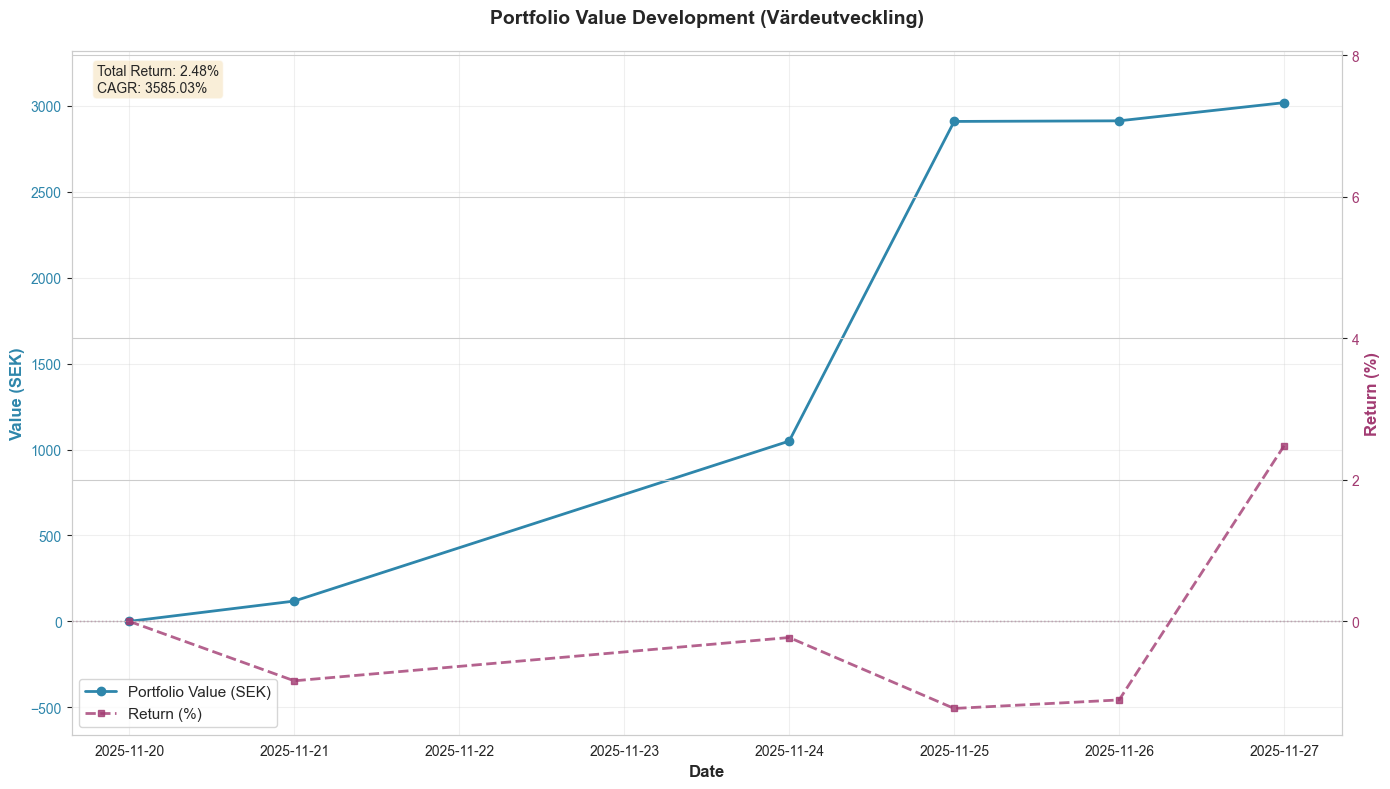

In [65]:
# Create graph of portfolio value development (värdeutveckling)
# Group by date and take the latest value per day
portfolio_df['Date_Only'] = portfolio_df['Date'].dt.date
daily_df = portfolio_df.groupby('Date_Only').last().reset_index()
daily_df['Date_Only'] = pd.to_datetime(daily_df['Date_Only'])

# Add initial 0 point at the start (before first event)
initial_date = pd.to_datetime('2025-11-20')
initial_row = pd.DataFrame({
    'Date_Only': [initial_date],
    'Portfolio_Value': [0],
    'Cash': [0],
    'NAV': [0],
    'Total_Fees': [0],
    'P&L': [0]
})
daily_df = pd.concat([initial_row, daily_df], ignore_index=True)

# Calculate percentage change based on cumulative deposits up to each date
# We need to track cumulative deposits for each date
if len(cashflows_df) > 0:
    # Get deposits sorted by date
    deposits_df = cashflows_df[cashflows_df['Type'] == 'Deposit'].copy()
    deposits_df = deposits_df.sort_values('Date')
    deposits_df['Cumulative_Deposits'] = deposits_df['Original_Amount'].cumsum()
    
    # For each date in daily_df, find cumulative deposits up to that date
    daily_df['Cumulative_Deposits'] = daily_df['Date_Only'].apply(
        lambda date: deposits_df[deposits_df['Date'] <= date]['Original_Amount'].sum() 
        if len(deposits_df[deposits_df['Date'] <= date]) > 0 else 0
    )
    # Set cumulative deposits to 0 for the initial row
    daily_df.loc[daily_df['Portfolio_Value'] == 0, 'Cumulative_Deposits'] = 0
else:
    # Fallback: use buys as deposits
    buys_df = trades_df[trades_df['Quantity'] > 0].copy()
    buys_df = buys_df.sort_values('Date')
    buys_df['Cumulative_Deposits'] = abs(buys_df['Total_Value']).cumsum()
    
    daily_df['Cumulative_Deposits'] = daily_df['Date_Only'].apply(
        lambda date: abs(buys_df[buys_df['Date'] <= date]['Total_Value']).sum()
        if len(buys_df[buys_df['Date'] <= date]) > 0 else 0
    )
    # Set cumulative deposits to 0 for the initial row
    daily_df.loc[daily_df['Portfolio_Value'] == 0, 'Cumulative_Deposits'] = 0

# Calculate percentage return: (Portfolio Value - Cumulative Deposits) / Cumulative Deposits * 100
# Handle division by zero - set to 0 for initial row and when no deposits yet
daily_df['Percent_Change'] = daily_df.apply(
    lambda row: ((row['Portfolio_Value'] - row['Cumulative_Deposits']) / row['Cumulative_Deposits'] * 100) 
    if row['Cumulative_Deposits'] > 0 else 0, 
    axis=1
)

# Debug: Print values to see what's happening
print("DEBUG: Portfolio values and percentage changes:")
print("\nDate | Portfolio Value | Cumulative Deposits | Percent Change")
print("-" * 70)
for idx, row in daily_df.iterrows():
    print(f"{row['Date_Only'].strftime('%Y-%m-%d')} | {row['Portfolio_Value']:,.2f} | {row['Cumulative_Deposits']:,.2f} | {row['Percent_Change']:.2f}%")
print("\n")

fig, ax1 = plt.subplots(figsize=(14, 8))

# Plot portfolio value on left y-axis
ax1.plot(daily_df['Date_Only'], daily_df['Portfolio_Value'], 
         marker='o', linewidth=2, markersize=6, label='Portfolio Value (SEK)', color='#2E86AB')
ax1.set_xlabel('Date', fontsize=12, fontweight='bold')
ax1.set_ylabel('Value (SEK)', fontsize=12, fontweight='bold', color='#2E86AB')
ax1.tick_params(axis='y', labelcolor='#2E86AB')
ax1.grid(True, alpha=0.3)

# Add zero line for value
ax1.axhline(y=0, color='gray', linestyle=':', linewidth=1, alpha=0.5)

# Create second y-axis for percentage change
ax2 = ax1.twinx()
ax2.plot(daily_df['Date_Only'], daily_df['Percent_Change'], 
         marker='s', linewidth=2, markersize=5, label='Return (%)', color='#A23B72', linestyle='--', alpha=0.8)
ax2.set_ylabel('Return (%)', fontsize=12, fontweight='bold', color='#A23B72')
ax2.tick_params(axis='y', labelcolor='#A23B72')

# Add zero line for percentage
ax2.axhline(y=0, color='#A23B72', linestyle=':', linewidth=1, alpha=0.3)

# Align both y-axes so zero lines are at the same height
# Get the data ranges
y1_min, y1_max = daily_df['Portfolio_Value'].min(), daily_df['Portfolio_Value'].max()
y2_min, y2_max = daily_df['Percent_Change'].min(), daily_df['Percent_Change'].max()

# Add padding (10% of range)
y1_range = y1_max - y1_min
y2_range = y2_max - y2_min
y1_padding = y1_range * 0.1 if y1_range > 0 else abs(y1_max) * 0.1 if y1_max != 0 else 1
y2_padding = y2_range * 0.1 if y2_range > 0 else abs(y2_max) * 0.1 if y2_max != 0 else 1

# Calculate where zero is positioned in the data range (as a fraction 0-1)
# This tells us how much of the range is below zero vs above zero
if y1_min <= 0 <= y1_max:
    y1_zero_fraction = (0 - y1_min) / y1_range if y1_range > 0 else 0.5
else:
    y1_zero_fraction = None

if y2_min <= 0 <= y2_max:
    y2_zero_fraction = (0 - y2_min) / y2_range if y2_range > 0 else 0.5
else:
    y2_zero_fraction = None

# Determine target zero position (use average if both have zero, otherwise use the one that has it)
if y1_zero_fraction is not None and y2_zero_fraction is not None:
    target_zero_fraction = (y1_zero_fraction + y2_zero_fraction) / 2
elif y1_zero_fraction is not None:
    target_zero_fraction = y1_zero_fraction
elif y2_zero_fraction is not None:
    target_zero_fraction = y2_zero_fraction
else:
    target_zero_fraction = 0.5  # Default to middle if neither has zero

# Calculate new limits that include all data AND align zero at target position
# For y1 (Portfolio Value)
if y1_zero_fraction is not None:
    # Zero is in the data range - align it
    # We need: new_min + target_zero_fraction * (new_max - new_min) = 0
    # And we need: new_min <= y1_min - padding, new_max >= y1_max + padding
    # Solve: new_min = -target_zero_fraction * (new_max - new_min)
    # Let total_range = new_max - new_min
    # new_min = -target_zero_fraction * total_range
    # new_max = (1 - target_zero_fraction) * total_range
    # We need total_range such that new_min <= y1_min - padding and new_max >= y1_max + padding
    required_range_below = abs(y1_min - y1_padding) / target_zero_fraction if target_zero_fraction > 0 else 0
    required_range_above = (y1_max + y1_padding) / (1 - target_zero_fraction) if target_zero_fraction < 1 else 0
    y1_total_range = max(required_range_below, required_range_above, y1_range + 2 * y1_padding)
    y1_new_min = -target_zero_fraction * y1_total_range
    y1_new_max = (1 - target_zero_fraction) * y1_total_range
else:
    # Zero is not in range - just add padding
    y1_new_min = y1_min - y1_padding
    y1_new_max = y1_max + y1_padding

# For y2 (Percent Change)
if y2_zero_fraction is not None:
    # Zero is in the data range - align it
    required_range_below = abs(y2_min - y2_padding) / target_zero_fraction if target_zero_fraction > 0 else 0
    required_range_above = (y2_max + y2_padding) / (1 - target_zero_fraction) if target_zero_fraction < 1 else 0
    y2_total_range = max(required_range_below, required_range_above, y2_range + 2 * y2_padding)
    y2_new_min = -target_zero_fraction * y2_total_range
    y2_new_max = (1 - target_zero_fraction) * y2_total_range
else:
    # Zero is not in range - just add padding
    y2_new_min = y2_min - y2_padding
    y2_new_max = y2_max + y2_padding

# Set the limits
ax1.set_ylim(y1_new_min, y1_new_max)
ax2.set_ylim(y2_new_min, y2_new_max)

# Title
ax1.set_title('Portfolio Value Development (Värdeutveckling)', fontsize=14, fontweight='bold', pad=20)

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='best', fontsize=11)

# Format x-axis dates
plt.xticks(rotation=45)
plt.tight_layout()

# Add statistics text box
stats_text = f'Total Return: {total_return_pct:.2f}%\nCAGR: {cagr:.2f}%'
ax1.text(0.02, 0.98, stats_text, transform=ax1.transAxes, 
         fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.show()



In [66]:
# Display current portfolio summary
print("\nCURRENT PORTFOLIO SUMMARY")

if current_positions:
    print("\nOpen Positions:")
    positions_summary = []
    # Get purchase prices from the last portfolio history entry
    last_positions = portfolio_history[-1]['Positions'] if portfolio_history else {}
    
    # Reconstruct purchase prices from trades (latest buy price for each stock)
    purchase_prices_summary = {}
    for stock in current_positions.keys():
        buy_trades = trades_df[(trades_df['Stock'] == stock) & (trades_df['Quantity'] > 0)]
        if len(buy_trades) > 0:
            purchase_prices_summary[stock] = buy_trades.iloc[-1]['Price']
    
    for stock, qty in current_positions.items():
        if stock in purchase_prices_summary:
            purchase_price = purchase_prices_summary[stock]
            nav_value = qty * purchase_price
            positions_summary.append({
                'Stock': stock,
                'Quantity': qty,
                'Purchase Price': purchase_price,
                'NAV': nav_value
            })
    
    positions_summary_df = pd.DataFrame(positions_summary)
    display(positions_summary_df)
else:
    print("\nNo open positions")

# Create summary DataFrame using current values from portfolio_df
summary_data = {
    'Metric': ['Total Deposits', 'Total Fees', 'Cash', 'NAV', 'Portfolio Value', 'P&L'],
    'Value (SEK)': [
        total_deposits,
        current_total_fees,
        current_cash,
        current_nav,
        current_portfolio_value,
        current_pnl
    ]
}
summary_df = pd.DataFrame(summary_data)
display(summary_df)




CURRENT PORTFOLIO SUMMARY

No open positions


,Metric,Value (SEK)
0,Total Deposits,2945.39
1,Total Fees,10.59
2,Cash,3018.47
3,NAV,0.00
4,Portfolio Value,3018.47
5,P&L,73.08
